<a href="https://colab.research.google.com/github/Stepka/Currency-Detection/blob/master/Currency_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the latest Tensorflow version.
!pip3 install --quiet tensorflow==1.13.1
!pip3 install --quiet --upgrade tensorflow-probability
!pip3 install --quiet tensorflow-hub
!pip3 install ciso8601

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import ciso8601
import time
import datetime
import math

W0423 15:13:00.713886 139785186838400 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:


print("TensorFlow version:", tf.__version__)
print("TensorFlow probability version:", tfp.__version__)
print("Pandas version:", pd.__version__)
tf.executing_eagerly()

TensorFlow version: 1.13.1
TensorFlow probability version: 0.6.0
Pandas version: 0.24.2


False

# Step 1 - Load data (from google drive)


In [4]:
from google.colab import drive
drive.mount('/drive')

default_path = "/drive/My Drive/Colab Notebooks/Currency Detection/data/"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
dataset_df = pd.read_csv(default_path + "AU000000RNE2.csv")

# Step 2 - Сlean and research data


In [6]:

print("Num rows: {}\n".format(len(dataset_df.index)))

dataset_df.head(10)

Num rows: 815



,TRADE_TIMESTAMP,ISIN,PRICE,CURRENCY
0,2018-01-02 22:28:01.747,AU000000RNE2,0.030,EUR
1,2018-01-03 02:17:53.896,AU000000RNE2,0.030,EUR
2,2018-01-03 09:57:12.584,AU000000RNE2,0.018,AUD
3,2018-01-03 22:09:31.159,AU000000RNE2,0.007,EUR
4,2018-01-04 02:22:08.771,AU000000RNE2,0.007,EUR
5,2018-01-04 09:56:58.543,AU000000RNE2,0.018,AUD
6,2018-01-04 14:39:23.572,AU000000RNE2,0.018,AUD
7,2018-01-04 22:26:53.198,AU000000RNE2,0.001,EUR
8,2018-01-05 02:28:35.177,AU000000RNE2,0.001,EUR
9,2018-01-05 09:59:46.338,AU000000RNE2,0.019,AUD


In [7]:
dataset_df['TRADE_TIMESTAMP_HOUR'] = dataset_df['TRADE_TIMESTAMP'].map(lambda s: int(time.mktime(ciso8601.parse_datetime(s).timetuple()) / (60*60)))

dataset_df.head()

,TRADE_TIMESTAMP,ISIN,PRICE,CURRENCY,TRADE_TIMESTAMP_HOUR
0,2018-01-02 22:28:01.747,AU000000RNE2,0.030,EUR,420814
1,2018-01-03 02:17:53.896,AU000000RNE2,0.030,EUR,420818
2,2018-01-03 09:57:12.584,AU000000RNE2,0.018,AUD,420825
3,2018-01-03 22:09:31.159,AU000000RNE2,0.007,EUR,420838
4,2018-01-04 02:22:08.771,AU000000RNE2,0.007,EUR,420842


In [8]:
dataset_df.groupby('ISIN').describe()

PRICE                                                         \
              count      mean       std     min    25%    50%    75%   max   
ISIN                                                                         
AU000000RNE2  815.0  0.007969  0.005102  0.0001  0.004  0.007  0.012  0.03   

             TRADE_TIMESTAMP_HOUR                                        \
                            count           mean          std       min   
ISIN                                                                      
AU000000RNE2                815.0  424532.982822  2059.477252  420814.0   

                                                      
                   25%       50%       75%       max  
ISIN                                                  
AU000000RNE2  422724.0  424678.0  426310.5  428038.0

In [0]:
dataset_df.drop(labels = ["ISIN", "TRADE_TIMESTAMP"], axis = 1, inplace = True)

In [10]:
dataset_df.groupby('CURRENCY').describe()

PRICE                                                             \
          count      mean       std     min     25%     50%    75%     max   
CURRENCY                                                                     
AUD       269.0  0.013457  0.002805  0.0070  0.0110  0.0140  0.016  0.0190   
EUR       423.0  0.004083  0.003022  0.0010  0.0020  0.0040  0.005  0.0300   
USD       123.0  0.009332  0.002043  0.0001  0.0083  0.0083  0.009  0.0134   

         TRADE_TIMESTAMP_HOUR                                                  \
                        count           mean          std       min       25%   
CURRENCY                                                                        
AUD                     269.0  424338.185874  2027.979601  420825.0  422558.0   
EUR                     423.0  424433.241135  2103.900275  420814.0  422590.5   
USD                     123.0  425302.016260  1799.897420  421463.0  424502.5   

                                        
               50%       75%       max  
CURRENCY                                
AUD       424354.0  426083.0  428025.0  
EUR       424463.0  426240.0  428038.0  
USD       425544.0  426708.0  428016.0

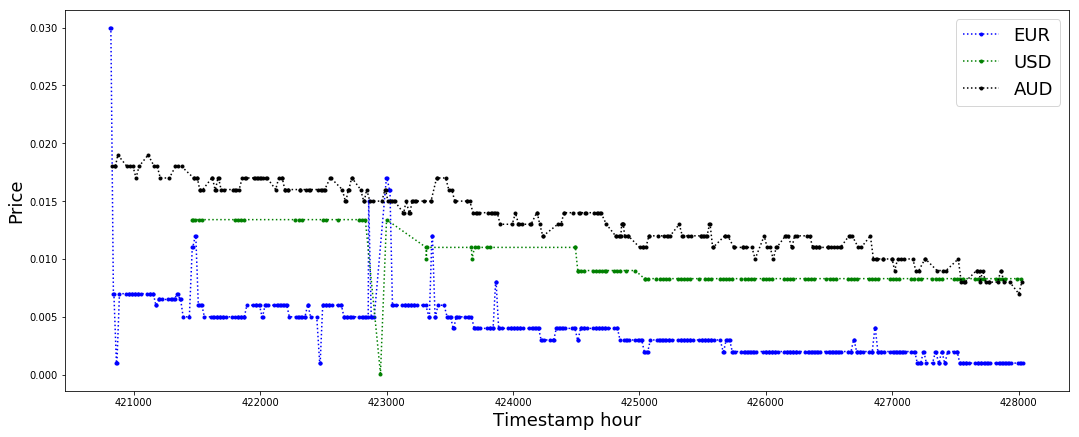

In [11]:
def subplot_currency(plt_, df, currency_, color_):
  plt_.plot(df[df['CURRENCY'] == currency_]['TRADE_TIMESTAMP_HOUR'], df[df['CURRENCY'] == currency_]['PRICE'], color=color_, label=currency_, linestyle=':', marker='.')
  
def plot_currencies(df):  
  plt.figure(figsize = (18,7))
  subplot_currency(plt, df, 'EUR', 'blue')
  subplot_currency(plt, df, 'USD', 'green')
  subplot_currency(plt, df, 'AUD', 'black')
  plt.xlabel('Timestamp hour', fontsize=18)
  plt.ylabel('Price', fontsize=18)
  plt.legend(fontsize=18)
  plt.show()
  
plot_currencies(dataset_df)

In [0]:
# Outlier detection 

def detect_outliers(df, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() )
    
    return multiple_outliers   

[0, 1, 7, 8, 33, 34, 36, 37, 39, 53, 55, 57, 61, 63, 55, 57, 61, 63, 113, 125, 126, 150, 171, 172, 171, 172, 189, 190, 191, 219, 229, 231, 233, 234, 267, 268, 271, 272, 273, 274, 271, 272, 325, 326, 325, 326, 359, 360, 363, 364, 365, 366, 384, 386, 384, 386, 422, 425, 427, 454, 456, 459, 461, 454, 456, 459, 461, 531, 533, 543, 545, 548, 530, 536, 538, 540, 542, 661, 663, 661, 663, 679, 681, 679, 681, 719, 721, 723, 725, 730, 749, 750, 752]
[201, 267, 267, 339, 341, 398]
[5, 17, 17, 23, 30, 23, 30, 32, 81, 84, 85, 89, 120, 123, 124, 165, 166, 202, 203, 214, 215, 221, 222, 240, 241, 259, 260, 263, 292, 300, 316, 317, 321, 322, 325, 328, 371, 382, 383, 384, 385, 397, 400, 401, 404, 431, 431, 465, 466, 470, 471, 465, 466, 501, 505, 517, 546, 550, 589, 590, 594, 606, 629, 731]


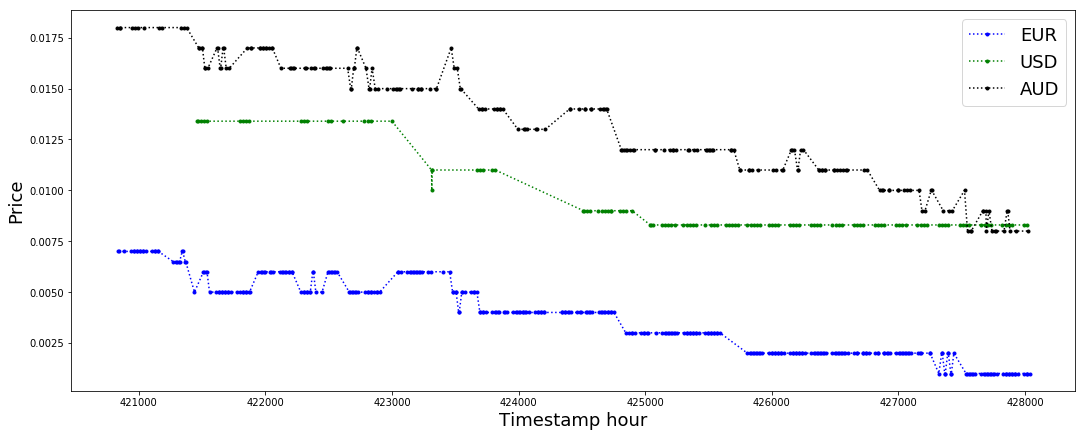

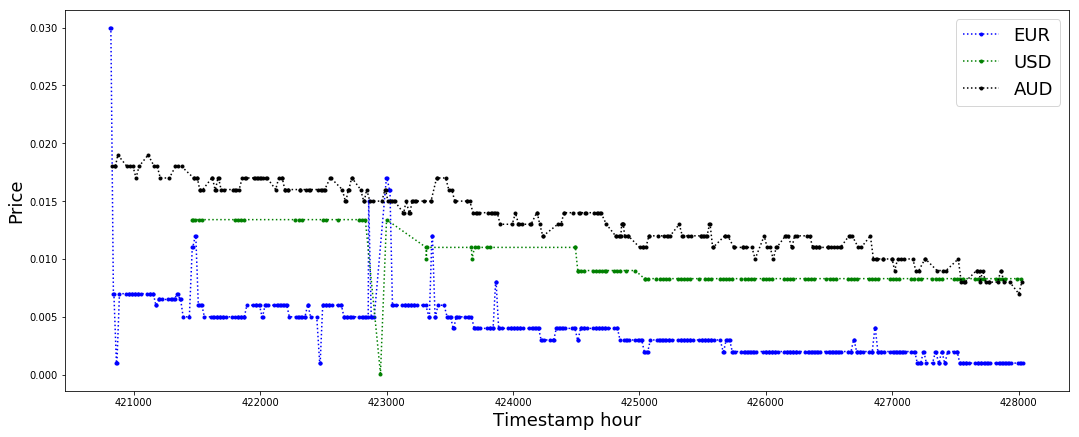

In [13]:
# detect outliers

def find_outliers(df, currency_, preiod=24*7):
  sub_df = df[df['CURRENCY'] == currency_]
  minimum = sub_df['TRADE_TIMESTAMP_HOUR'].min()
  num_sub_series = math.ceil((sub_df['TRADE_TIMESTAMP_HOUR'].max() - minimum) / preiod)
  indexes = []
  for delta in range(num_sub_series):
    start_hour = minimum + preiod * delta
    end_hour = minimum + preiod * (delta + 1)
    perioded_sub_df = sub_df[(sub_df['TRADE_TIMESTAMP_HOUR'] >= start_hour - preiod/2) & (sub_df['TRADE_TIMESTAMP_HOUR'] <= end_hour + preiod/2)]
    if len(perioded_sub_df) > 0:
      detected = detect_outliers(perioded_sub_df, ['PRICE'])
      indexes.extend(detected)
    
  print(indexes)
  return indexes

cleaned_dataset_df = dataset_df.copy()

outliers_indexes = find_outliers(cleaned_dataset_df, 'EUR')
cleaned_dataset_df = cleaned_dataset_df.drop(outliers_indexes, axis = 0).reset_index(drop=True)
outliers_indexes = find_outliers(cleaned_dataset_df, 'USD')
cleaned_dataset_df = cleaned_dataset_df.drop(outliers_indexes, axis = 0).reset_index(drop=True)
outliers_indexes = find_outliers(cleaned_dataset_df, 'AUD')
cleaned_dataset_df = cleaned_dataset_df.drop(outliers_indexes, axis = 0).reset_index(drop=True)



plot_currencies(cleaned_dataset_df)
plot_currencies(dataset_df)

# Step 3 - Build model


In [0]:
def build_model(sub_df):

  X = sub_df['TRADE_TIMESTAMP_HOUR'].values
  
  X = X.reshape(-1,1)
  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  X = X.reshape(-1)

  y = sub_df['PRICE']

  degrees = [1, 2, 3, 40]

  polynomial_features = PolynomialFeatures(degree=8,
                                           include_bias=False)
  linear_regression = LinearRegression()
  pipeline = Pipeline([("polynomial_features", polynomial_features),
                       ("linear_regression", linear_regression)])

  pipeline.fit(X[:, np.newaxis], y)

  # Evaluate the models using crossvalidation
  scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                           scoring="neg_mean_squared_error", cv=10)
  
  return pipeline, scaler

In [0]:
def plot_model_currencies(df):  
  plt.figure(figsize = (18,7))
  plot_model_currency(df, 'EUR', 'blue')
  plot_model_currency(df, 'USD', 'green')
  plot_model_currency(df, 'AUD', 'black')
  plt.xlabel('Timestamp hour', fontsize=18)
  plt.ylabel('Price', fontsize=18)
  plt.legend(fontsize=18)
  plt.show()

def plot_model_currency(df, currency_, color_):

  currency_model, currency_scaler = build_model(df[df['CURRENCY'] == currency_])
  
  X_test = np.linspace(currency_scaler.data_min_, currency_scaler.data_max_, 10000)
  X_test_reshaped = X_test.reshape(-1,1)

  plt.plot(X_test, currency_model.predict(currency_scaler.transform(X_test_reshaped)), label=currency_+" Model")
  subplot_currency(plt, df, currency_, color_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


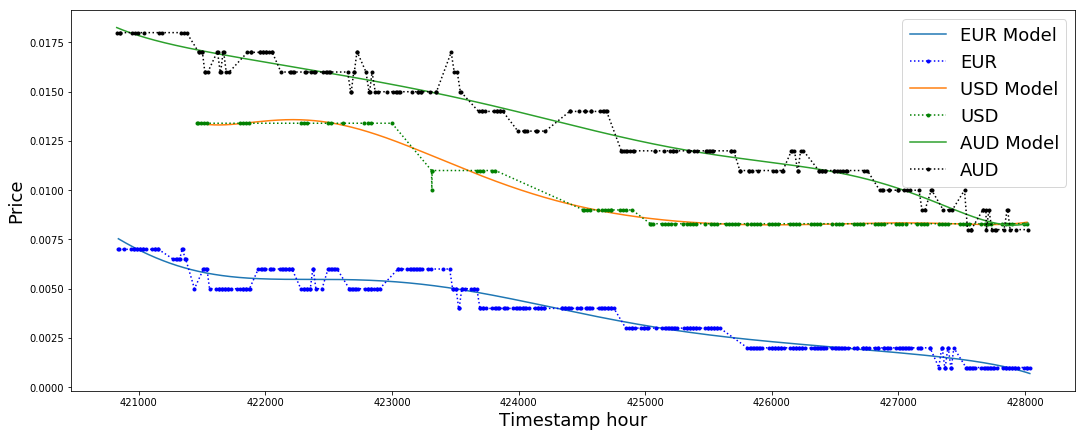

In [16]:
plot_model_currencies(cleaned_dataset_df)

In [17]:
aud_model, aud_scaler = build_model(cleaned_dataset_df[cleaned_dataset_df['CURRENCY'] == 'AUD'])
eur_model, eur_scaler = build_model(cleaned_dataset_df[cleaned_dataset_df['CURRENCY'] == 'EUR'])
usd_model, usd_scaler = build_model(cleaned_dataset_df[cleaned_dataset_df['CURRENCY'] == 'USD'])
  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
def which_currency(df, threshold=0.001):
  
  currency_names = ['AUD', 'EUR', 'USD']
  
  def get_currency_name(pred):
    if pred[0] < threshold:
      return currency_names[int(pred[1])]
    return 'UNKNOWN'
  
  price_data = df['PRICE']
  
  time_data = df['TRADE_TIMESTAMP_HOUR'].values
  time_data_reshaped = time_data.reshape(-1,1)
  
  aud_prediction = aud_model.predict(aud_scaler.transform(time_data_reshaped))
  eur_prediction = eur_model.predict(eur_scaler.transform(time_data_reshaped))
  usd_prediction = usd_model.predict(usd_scaler.transform(time_data_reshaped))
  
  diff_matrix = np.zeros((3, len(time_data)))
  diff_matrix[0] = (price_data - aud_prediction).map(math.fabs)
  diff_matrix[1] = (price_data - eur_prediction).map(math.fabs)
  diff_matrix[2] = (price_data - usd_prediction).map(math.fabs)
    
  predictions = np.array((np.min(diff_matrix, axis=0), np.argmin(diff_matrix, axis=0)))
  predictions = np.transpose(predictions)
  
  predictions = [get_currency_name(xi) for xi in predictions]
  return predictions

In [19]:
samples = dataset_df.sample(n=10)

result = which_currency(samples)

samples['PREDICTED'] = result

print(samples)

      PRICE CURRENCY  TRADE_TIMESTAMP_HOUR PREDICTED
131  0.0170      AUD                422054       AUD
675  0.0020      EUR                426838       EUR
251  0.0140      AUD                423183   UNKNOWN
453  0.0110      AUD                425031   UNKNOWN
163  0.0160      AUD                422361       AUD
153  0.0050      EUR                422302       EUR
610  0.0083      USD                426310       USD
113  0.0060      EUR                421894       EUR
507  0.0120      AUD                425483       AUD
649  0.0020      EUR                426578       EUR
